# Part 2: Line segmentation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

root_dir = "/content/data"

Mounted at /content/drive


## Import Library and Data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import os
import zipfile

import re
import cv2

from heapq import heappush, heappop
from PIL import Image

In [ ]:
zip_file_name = 'drive/MyDrive/colab/paragraph_images.zip'
base_path = "extracted_files/"
paragraphe_list = []

In [ ]:
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('/content/extracted_files/')

In [ ]:
folder_path = base_path

def extract_index_and_i(filename):
    pattern = r'image_(\d+)_bb_(\d+)\.png'  # Define the regex pattern
    match = re.match(pattern, filename)

    if match:
        index = match.group(1)
        i = match.group(2)
        return int(index), int(i)

    return None, None  # Return None if no match is found

# Check if the folder exists
if os.path.exists(base_path):
    for root, directories, files in os.walk(base_path):
        for file in files:
          index, i = extract_index_and_i(file)
          file_path = os.path.join(root, file)

          while len(paragraphe_list) <= index:
                    paragraphe_list.append([])

          while len(paragraphe_list[index]) < i:
                    paragraphe_list[index].append(None)

          paragraphe_list[index][i - 1] = file_path


else:
    print(f"The folder '{folder_path}' does not exist.")

In [ ]:
len(paragraphe_list)

10

In [ ]:
# Display the paragraph_list
for index, paragraph in enumerate(paragraphe_list):
    print(f"Index {index}: {paragraph}")

Index 0: ['extracted_files/image_0_bb_1.png', 'extracted_files/image_0_bb_2.png']
Index 1: ['extracted_files/image_1_bb_1.png', 'extracted_files/image_1_bb_2.png']
Index 2: ['extracted_files/image_2_bb_1.png', 'extracted_files/image_2_bb_2.png']
Index 3: ['extracted_files/image_3_bb_1.png', 'extracted_files/image_3_bb_2.png']
Index 4: ['extracted_files/image_4_bb_1.png', 'extracted_files/image_4_bb_2.png']
Index 5: ['extracted_files/image_5_bb_1.png', 'extracted_files/image_5_bb_2.png']
Index 6: ['extracted_files/image_6_bb_1.png', 'extracted_files/image_6_bb_2.png']
Index 7: ['extracted_files/image_7_bb_1.png', 'extracted_files/image_7_bb_2.png']
Index 8: ['extracted_files/image_8_bb_1.png', 'extracted_files/image_8_bb_2.png']
Index 9: ['extracted_files/image_9_bb_1.png', 'extracted_files/image_9_bb_2.png']


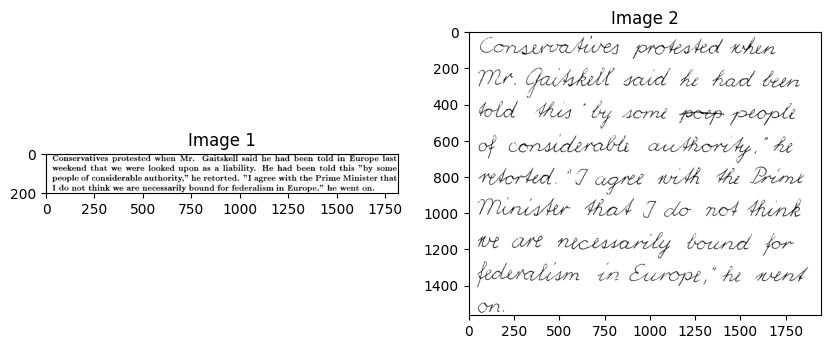

In [ ]:
# Load the grayscale image
image1 = cv2.imread(paragraphe_list[0][0], cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread(paragraphe_list[0][1], cv2.IMREAD_GRAYSCALE)

# Display the original and binary images using matplotlib
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image1, cmap='gray')
plt.title('Image 1')

plt.subplot(1, 2, 2)
plt.imshow(image2, cmap='gray')
plt.title('Image 2')

plt.show()

In [ ]:
image2 = cv2.imread(paragraphe_list[0][1], cv2.IMREAD_GRAYSCALE)
_, binary_image = cv2.threshold(image2, 128, 255, cv2.THRESH_BINARY)

In [ ]:
binary_image

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [ ]:
binary_images = []

# Iterate through each item in paragraphe_list
for paragraph_info in paragraphe_list:
    image_path = paragraph_info[1]

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)

    binary_images.append(binary)

## Processing

### Horizontal Projection Profile (HPP) Calculation:
Compute HPP: Calculate the Horizontal Projection Profile by summing the pixel values along each row of the binarized image.

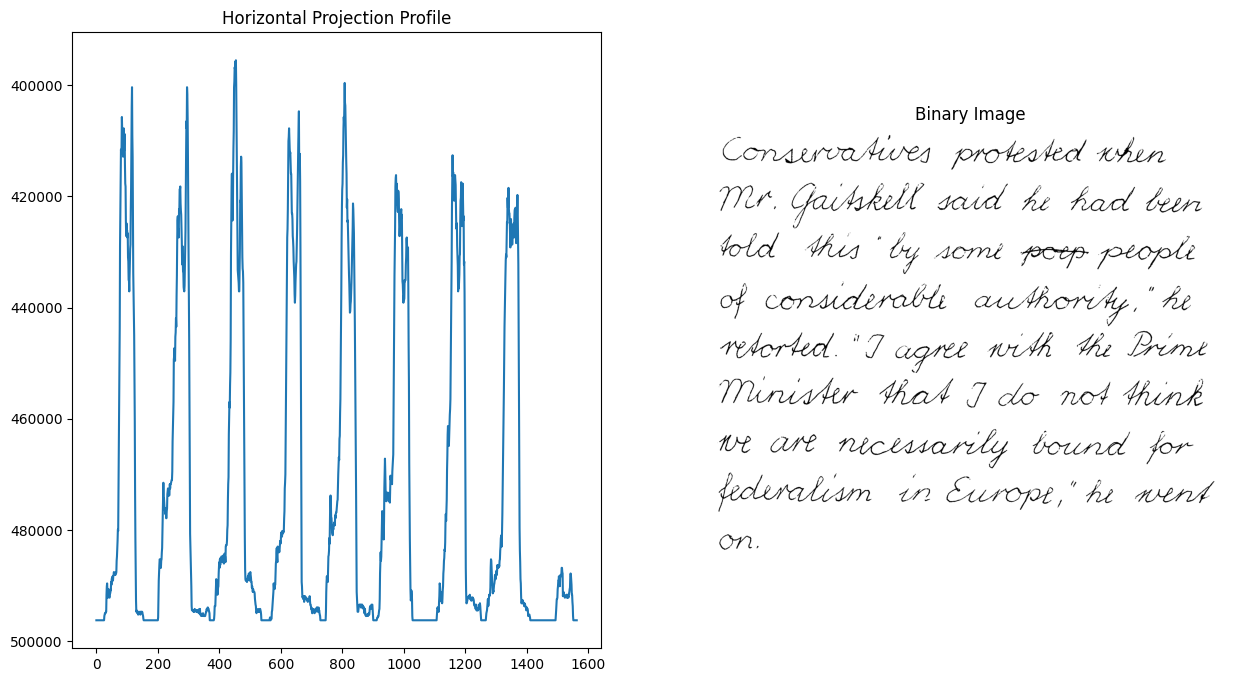

In [ ]:
def horizontal_projections(binary_image):
    return np.sum(binary_image, axis=1)

# Calculate Horizontal Projection Profile (HPP)
hpp = horizontal_projections(binary_image)

# Plotting both images
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# Plot horizontal projection profile
ax1.set_title("Horizontal Projection Profile")
ax1.plot(hpp)
ax1.invert_yaxis()  # Invert y-axis for the first image (HPP)


# Display binarized image
ax2.axis("off")
ax2.set_title("Binary Image")
ax2.imshow(binary_image, cmap="gray")

plt.show()

## Identify Peaks:
Find peaks or regions with higher values in the HPP, indicating potential line separations.

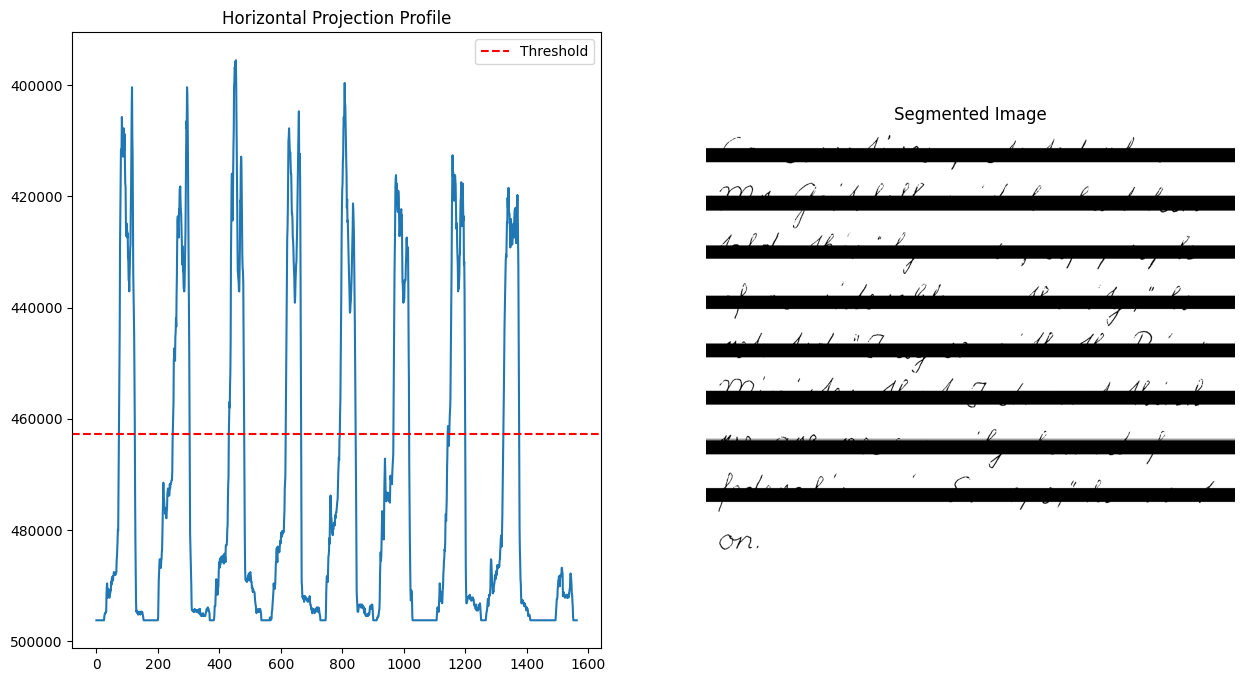

In [ ]:
# find the midway where we can make a threshold and extract the peaks regions
def find_peak_regions(hpp, threshold):

    peaks = []
    for i, hppv in enumerate(hpp):
        if hppv < threshold:
            peaks.append([i, hppv])
    return peaks

# Calculate Horizontal Projection Profile (HPP)
hpp = horizontal_projections(binary_image)
threshold = np.max(hpp) - ((np.max(hpp) - np.min(hpp)) / 3)

peaks = find_peak_regions(hpp, threshold)
peaks_indexes = np.array(peaks)[:, 0].astype(int)

# Create segmented image based on identified peaks
segmented_img = np.copy(binary_image)
r, c = segmented_img.shape
for ri in range(r):
    if ri in peaks_indexes:
        segmented_img[ri, :] = 0

# Plotting the original binary image with segmented regions
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# Plot horizontal projection profile
ax1.set_title("Horizontal Projection Profile")
ax1.plot(hpp)
ax1.axhline(y=threshold, color='r', linestyle='--', label='Threshold')  # Plot threshold line
ax1.invert_yaxis()  # Invert y-axis for the first image (HPP)
ax1.legend()  # Show legend

# Display the segmented image
ax2.axis("off")
ax2.set_title("Segmented Image")
ax2.imshow(segmented_img, cmap="gray")

plt.show()

In [ ]:
# Group the peaks for path planning
diff_between_consec_numbers = np.diff(peaks_indexes)
indexes_with_larger_diff = np.where(diff_between_consec_numbers > 1)[0].flatten()
peak_groups = np.split(peaks_indexes, indexes_with_larger_diff)
peak_groups = [item for item in peak_groups if len(item) > 10]

print("Peak groups found:", len(peak_groups))

Peak groups found: 8


## Problem

I have encountered 2 problems:
- The short line is not detected
- The paragraph is not correctly segmented

### Short line


In [ ]:
def calculate_peak_lengths_and_spaces(peak_groups):
    peak_lengths = []
    peak_spaces = []

    for group_idx in range(len(peak_groups) - 1):
        current_group = peak_groups[group_idx]
        next_group = peak_groups[group_idx + 1]

        if len(current_group) >= 2 and len(next_group) >= 2:
            space = next_group[1] - current_group[-1]
            peak_spaces.append(space)
            peak_lengths.append(len(current_group))

    return peak_lengths, peak_spaces

In [ ]:
peak_lengths, peak_spaces = calculate_peak_lengths_and_spaces(peak_groups)

mean_peak_space = np.mean(peak_spaces)
mean_peak_length = np.mean(peak_lengths)

# Calculate the last peak index
last_peak_index = peak_groups[-1][-1]
predicted_last_peak_index = last_peak_index + int(round(mean_peak_space))
predicted_new_peak_length = int(round(mean_peak_length))

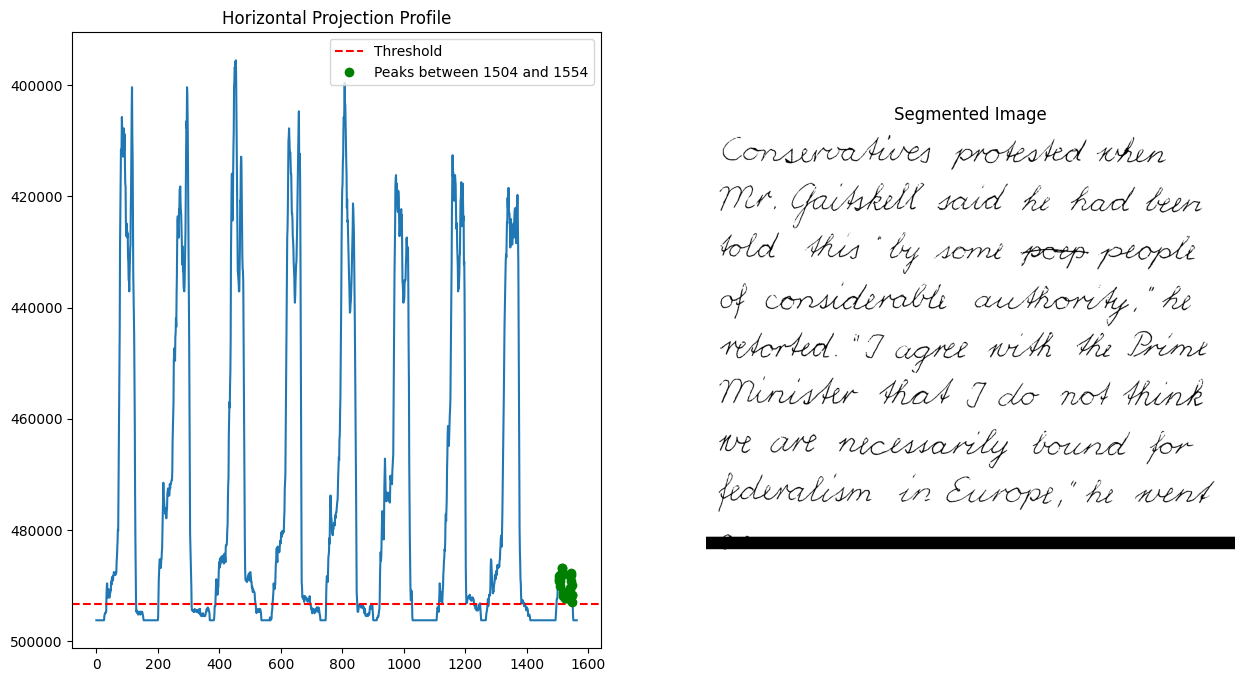

In [ ]:
# Function to find peaks within a specified range
def find_peaks_within_range(hpp, start_idx, end_idx, threshold):
    peaks_within_range = []
    for i in range(start_idx, end_idx):
        if hpp[i] < threshold:
            peaks_within_range.append([i, hpp[i]])
    return peaks_within_range

# Calculate Horizontal Projection Profile (HPP)
hpp = horizontal_projections(binary_image)
threshold = np.max(hpp) - 3000

# Display all peaks within the specified range
start_index = predicted_last_peak_index
if (predicted_last_peak_index + predicted_new_peak_length) > binary_image.shape[0]:
  end_index = predicted_last_peak_index + predicted_new_peak_length
else:
    end_index = binary_image.shape[0] - 1

peaks_within_range = find_peaks_within_range(hpp, start_index, end_index, threshold)
peaks_indexes_within_range = np.array(peaks_within_range)[:, 0].astype(int)

# Create segmented image based on identified peaks
segmented_img = np.copy(binary_image)
r, c = segmented_img.shape
for ri in range(r):
    if ri in peaks_indexes_within_range:
        segmented_img[ri, :] = 0

# Plotting the original binary image with segmented regions
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# Plot horizontal projection profile
ax1.set_title("Horizontal Projection Profile")
ax1.plot(hpp)
ax1.axhline(y=threshold, color='r', linestyle='--', label='Threshold')  # Plot threshold line


ax1.plot(peaks_indexes_within_range, np.array(peaks_within_range)[:, 1], 'go', label='Peaks between 1504 and 1554')  # Plot identified peaks
ax1.legend()  # Show legend

ax1.invert_yaxis()  # Invert y-axis for the first image (HPP)

# Display the segmented image
ax2.axis("off")
ax2.set_title("Segmented Image")
ax2.imshow(segmented_img, cmap="gray")

plt.show()

In [ ]:
# Group the peaks for path planning
diff_between_consec_numbers = np.diff(peaks_indexes_within_range)
indexes_with_larger_diff = np.where(diff_between_consec_numbers > 1)[0].flatten()
new_peak_groups = np.split(peaks_indexes_within_range, indexes_with_larger_diff)
new_peak_groups = [item for item in new_peak_groups if len(item) > 10]

print("Peak groups found:", len(new_peak_groups))

Peak groups found: 1


In [ ]:
peak_groups.append(new_peak_groups[0])

In [ ]:
print("Updated Peak Groups:")
for idx, group in enumerate(peak_groups):
    print(f"Group {idx + 1}: {group}")

Updated Peak Groups:
Group 1: [ 74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124]
Group 2: [125 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265
 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283
 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301
 302]
Group 3: [303 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448
 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466
 467 468 469 470 471 472 473 474 475 476 477 478 479]
Group 4: [480 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632 633
 634 635 636 637 638 639 640 641 642 643 644 645 646 647 648 649 650 651
 652 653 654 655 656 657 658 659 660 661 662 663 664]
Group 5: [665 793 794 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809
 810 811 812 813 814 815 816

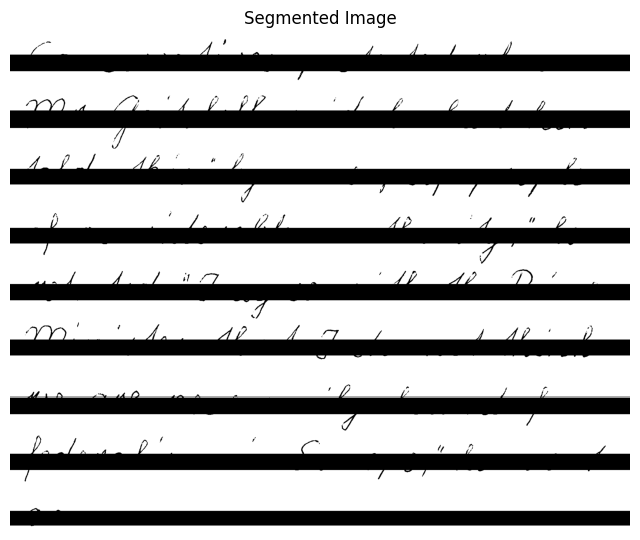

In [ ]:
# Create segmented image based on identified peak groups
segmented_img = np.copy(binary_image)
r, c = segmented_img.shape

for group in peak_groups:
    for ri in group:
        if ri < r:
            segmented_img[ri, :] = 0

# Display the segmented image
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Segmented Image")
plt.imshow(segmented_img, cmap="gray")
plt.show()

### Bad segmentation

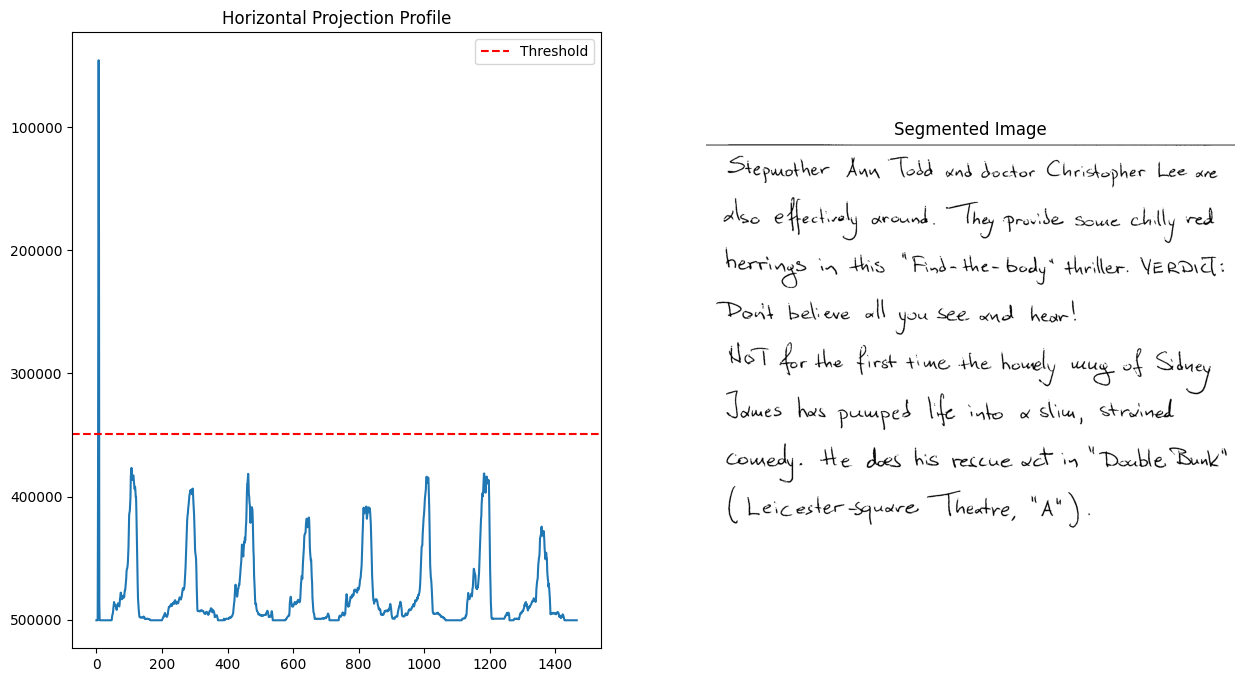

In [ ]:
# find the midway where we can make a threshold and extract the peaks regions
def find_peak_regions(hpp, threshold):

    peaks = []
    for i, hppv in enumerate(hpp):
        if hppv < threshold:
            peaks.append([i, hppv])
    return peaks

# Calculate Horizontal Projection Profile (HPP)
hpp = horizontal_projections(binary_images[1])
threshold = np.max(hpp) - ((np.max(hpp) - np.min(hpp)) / 3)

peaks = find_peak_regions(hpp, threshold)
peaks_indexes = np.array(peaks)[:, 0].astype(int)

# Create segmented image based on identified peaks
segmented_img = np.copy(binary_images[1])
r, c = segmented_img.shape
for ri in range(r):
    if ri in peaks_indexes:
        segmented_img[ri, :] = 0

# Plotting the original binary image with segmented regions
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# Plot horizontal projection profile
ax1.set_title("Horizontal Projection Profile")
ax1.plot(hpp)
ax1.axhline(y=threshold, color='r', linestyle='--', label='Threshold')  # Plot threshold line
ax1.invert_yaxis()  # Invert y-axis for the first image (HPP)
ax1.legend()  # Show legend

# Display the segmented image
ax2.axis("off")
ax2.set_title("Segmented Image")
ax2.imshow(segmented_img, cmap="gray")

plt.show()

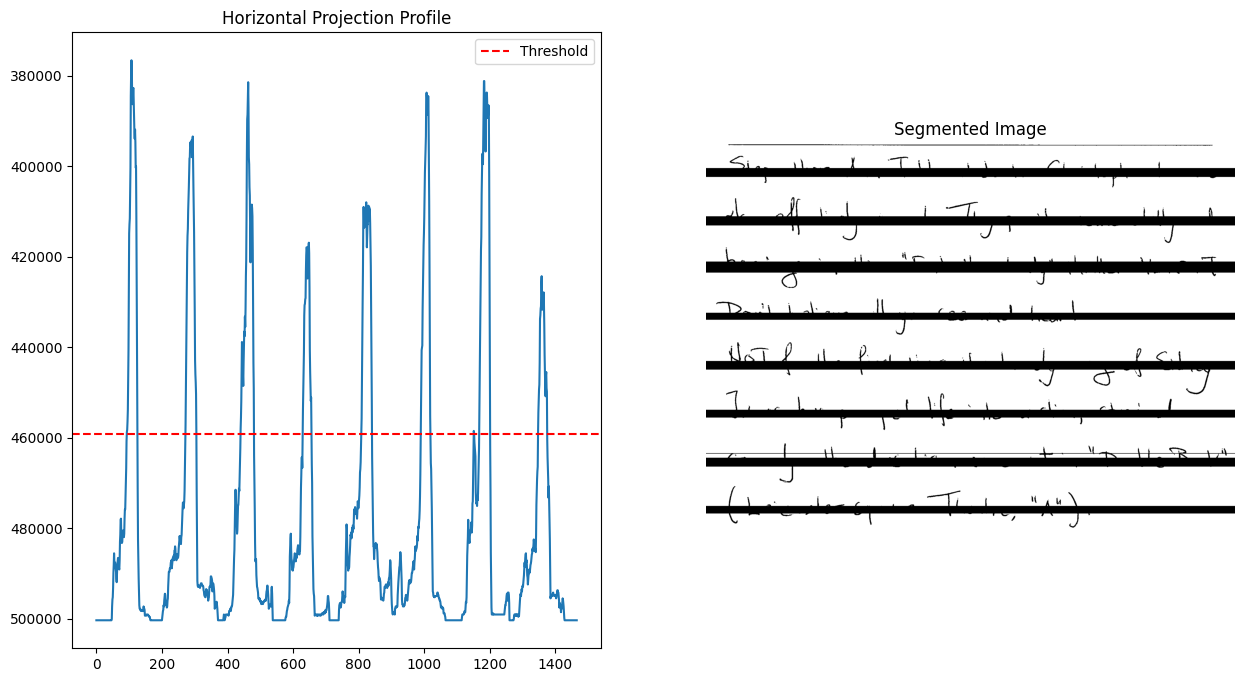

In [ ]:
if len(peaks_indexes) < 21:
    # Find the peak closest to the middle of the image
    middle_peak_index = int(len(hpp) / 2)
    closest_peak_index = min(peaks_indexes, key=lambda x: abs(x - middle_peak_index))

    # Define the range to remove around the identified peak
    removal_range = 30  # Adjust this value as needed to cover the entire peak region

    # Remove the entire peak region
    removal_start = max(0, closest_peak_index - removal_range)
    removal_end = min(len(hpp), closest_peak_index + removal_range)

    segmented_img[removal_start:removal_end, :] = 255  # Set to white

    # Recalculate HPP and threshold after removing the portion
    hpp = horizontal_projections(segmented_img)
    threshold = np.max(hpp) - ((np.max(hpp) - np.min(hpp)) / 3)

    # Find peaks again after removing the portion
    peaks = find_peak_regions(hpp, threshold)
    peaks_indexes = np.array(peaks)[:, 0].astype(int)

    # Create segmented image based on identified peaks after removal
    segmented_img = np.copy(binary_images[1])
    r, c = segmented_img.shape
    for ri in range(r):
        if ri in peaks_indexes:
            segmented_img[ri, :] = 0

    # Plotting the original binary image with segmented regions
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

    # Plot horizontal projection profile
    ax1.set_title("Horizontal Projection Profile")
    ax1.plot(hpp)
    ax1.axhline(y=threshold, color='r', linestyle='--', label='Threshold')  # Plot threshold line
    ax1.invert_yaxis()  # Invert y-axis for the first image (HPP)
    ax1.legend()  # Show legend

    # Display the segmented image
    ax2.axis("off")
    ax2.set_title("Segmented Image")
    ax2.imshow(segmented_img, cmap="gray")

    plt.show()

In [ ]:
# Group the peaks for path planning
diff_between_consec_numbers = np.diff(peaks_indexes)
indexes_with_larger_diff = np.where(diff_between_consec_numbers > 1)[0].flatten()
peak_groups = np.split(peaks_indexes, indexes_with_larger_diff)
peak_groups = [item for item in peak_groups if len(item) > 10]

print("Peak groups found:", len(peak_groups))

Peak groups found: 8


## A* algorithm

(148, 1945)


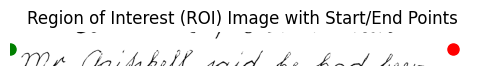

(136, 1945)


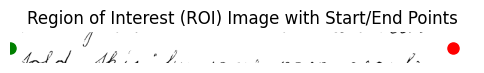

(151, 1945)


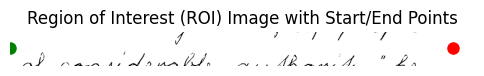

(155, 1945)


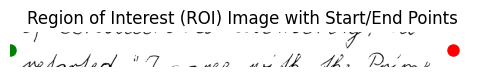

(151, 1945)


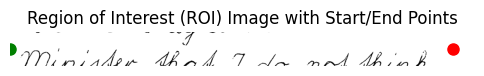

(151, 1945)


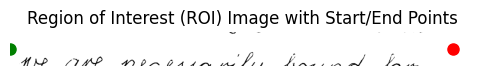

(148, 1945)


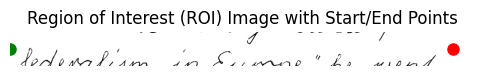

In [ ]:
# Loop through each peak group
for i in range(len(peak_groups) - 1):
    y_start = int(((peak_groups[i][1] + peak_groups[i][-1]) / 2 + (peak_groups[i + 1][1] + peak_groups[i + 1][-1]) / 2) / 2)
    y_end = y_start  # Same y-coordinate for the end point

    roi_start_x = 0
    roi_end_x = binary_image.shape[1] - 1
    roi_start_y = peak_groups[i][-1]
    roi_end_y = peak_groups[i + 1][1]

    roi_img = binary_image[roi_start_y:roi_end_y, roi_start_x:roi_end_x]
    print(roi_img.shape)
    # Visualize the roi_img with start and end points
    plt.figure(figsize=(6, 6))
    plt.imshow(roi_img, cmap='gray')
    plt.title('Region of Interest (ROI) Image with Start/End Points')

    # Plot start point on the roi_img
    plt.plot(0, y_start - roi_start_y, 'go', markersize=8, label='Start Point')  # Green 'go' marker

    # Plot end point on the roi_img
    plt.plot(roi_end_x - roi_start_x, y_end - roi_start_y, 'ro', markersize=8, label='End Point')  # Red 'ro' marker

    plt.axis('off')
    plt.show()

    start = (roi_start_x, y_start)
    end = (roi_end_x, y_end)

In [ ]:
# Define a function to calculate the Manhattan distance as the heuristic
def heuristic(a, b):
    return abs(b[0] - a[0]) + abs(b[1] - a[1])

# A* algorithm implementation
def astar(grid, start, end):
    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    open_set = []
    heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic(start, end)}

    while open_set:
        current = heappop(open_set)[1]

        if current == end:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j
            tentative_g_score = g_score[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < grid.shape[0] and 0 <= neighbor[1] < grid.shape[1]:
                if grid[neighbor[0]][neighbor[1]] == 0:  # Check for obstacles (0)
                    continue

                if tentative_g_score < g_score.get(neighbor, float('inf')):
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + heuristic(neighbor, end)
                    heappush(open_set, (f_score[neighbor], neighbor))

    return []

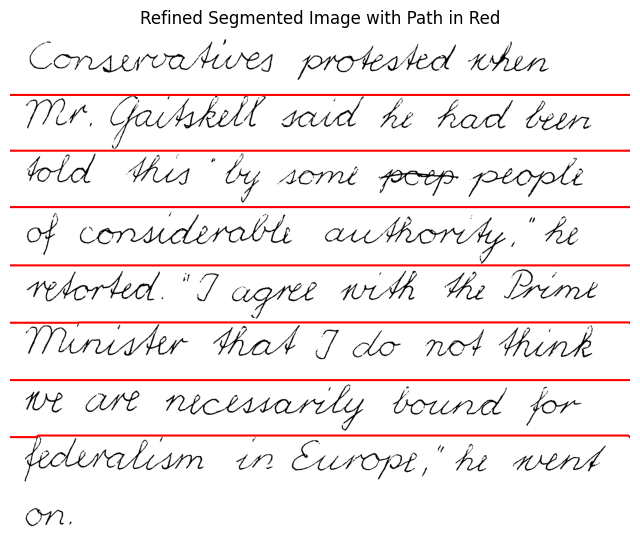

In [ ]:
# Create a figure outside the loop
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(binary_image, cmap='gray')
ax.set_title('Refined Segmented Image with Path in Red')
ax.axis('off')

# List to store all paths
all_paths = []

# Loop through each peak group
for i in range(len(peak_groups) - 1):
    y_start = int(((peak_groups[i][1] + peak_groups[i][-1]) / 2 + (peak_groups[i + 1][1] + peak_groups[i + 1][-1]) / 2) / 2)
    y_end = y_start  # Same y-coordinate for the end point

    start = (y_start, 0)
    end = (y_end, binary_image.shape[1] - 1)

    # Run A* algorithm on the region of interest
    path = astar(binary_image, start, end)

    # Collect paths to plot later
    if path:
        path = np.array(path)[:, ::-1]  # Reversing the path to match the (x, y) format for plotting
        ax.plot(path[:, 0], path[:, 1], color='red')  # Overlaying the path in red

        # Append the path to the list of all paths
        all_paths.append(path)

# Show the plot after all paths are plotted
plt.show()

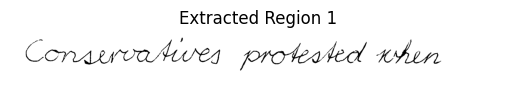

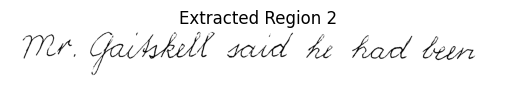

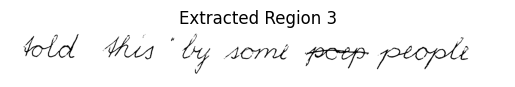

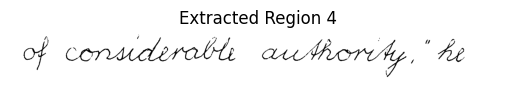

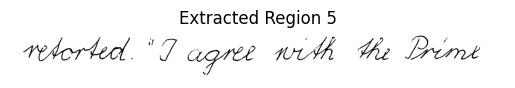

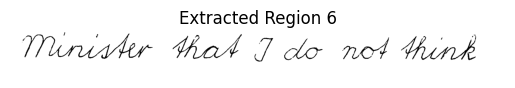

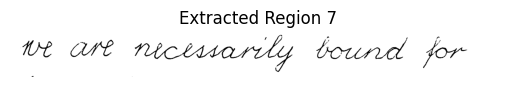

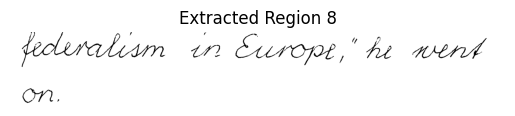

In [ ]:
# Extract and display regions between the red lines (paths)
for i, path in enumerate(all_paths):
    if i == 0:
        # Crop the region between the top and the first path generated by A*
        extracted_region = binary_image[:path[0, 1], :]
    else:
        # Crop the region between consecutive paths
        prev_path = all_paths[i - 1]
        extracted_region = binary_image[prev_path[0, 1]:path[0, 1], :]

    # Display the cropped region in a separate image
    plt.imshow(extracted_region, cmap='gray')
    plt.title(f'Extracted Region {i + 1}')
    plt.axis('off')
    plt.show()

# Extract the region between the last path and the bottom of the image
last_path = all_paths[-1]
extracted_region = binary_image[last_path[-1, 1]:, :]

# Display the cropped region in a separate image
plt.imshow(extracted_region, cmap='gray')
plt.title(f'Extracted Region {len(all_paths) + 1}')
plt.axis('off')
plt.show()

In [ ]:
# Define the folder path to save extracted regions
folder_path = 'extracted_regions1'

# Create the folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Extract and save regions between the red lines (paths)
if all_paths:
    for i, path in enumerate(all_paths):
        if i == 0:
            # Crop the region between the top and the first path generated by A*
            extracted_region = binary_image[:path[0, 1], :]
        else:
            # Crop the region between consecutive paths
            prev_path = all_paths[i - 1]
            extracted_region = binary_image[prev_path[0, 1]:path[0, 1], :]

        # Normalize the intensity values between 0 and 255
        extracted_region_normalized = ((extracted_region - extracted_region.min()) / (extracted_region.max() - extracted_region.min()) * 255).astype(np.uint8)

        # Save the extracted region as an image in the folder
        extracted_image = Image.fromarray(extracted_region_normalized)
        extracted_image.save(os.path.join(folder_path, f'extracted_region_{i + 1}.png'))

    # Extract the region between the last path and the bottom of the image
    last_path = all_paths[-1]
    extracted_region = binary_image[last_path[-1, 1]:, :]

    # Normalize the intensity values between 0 and 255
    extracted_region_normalized = ((extracted_region - extracted_region.min()) / (extracted_region.max() - extracted_region.min()) * 255).astype(np.uint8)

    # Save the extracted region as an image in the folder
    extracted_image = Image.fromarray(extracted_region_normalized)
    extracted_image.save(os.path.join(folder_path, f'extracted_region_{len(all_paths) + 1}.png'))

## Generalization

In [ ]:
general_folder_name = "segmented_line"
# Assuming binary_images is a list of binary images
for i, binary_image in enumerate(binary_images):
    # Perform processing steps for each binary image
    hpp = horizontal_projections(binary_image)
    threshold = np.max(hpp) - ((np.max(hpp) - np.min(hpp)) / 3)

    peaks = find_peak_regions(hpp, threshold)
    peaks_indexes = np.array(peaks)[:, 0].astype(int)


    if len(peaks_indexes) < 21:
      # Find the peak closest to the middle of the image
      middle_peak_index = int(len(hpp) / 2)
      closest_peak_index = min(peaks_indexes, key=lambda x: abs(x - middle_peak_index))

      # Define the range to remove around the identified peak
      removal_range = 30  # Adjust this value as needed to cover the entire peak region

      # Remove the entire peak region
      removal_start = max(0, closest_peak_index - removal_range)
      removal_end = min(len(hpp), closest_peak_index + removal_range)

      segmented_img[removal_start:removal_end, :] = 255  # Set to white

      # Recalculate HPP and threshold after removing the portion
      hpp = horizontal_projections(segmented_img)
      threshold = np.max(hpp) - ((np.max(hpp) - np.min(hpp)) / 3)

      # Find peaks again after removing the portion
      peaks = find_peak_regions(hpp, threshold)
      peaks_indexes = np.array(peaks)[:, 0].astype(int)


    # Group the peaks for path planning
    diff_between_consec_numbers = np.diff(peaks_indexes)
    indexes_with_larger_diff = np.where(diff_between_consec_numbers > 1)[0].flatten()
    peak_groups = np.split(peaks_indexes, indexes_with_larger_diff)
    peak_groups = [item for item in peak_groups if len(item) > 10]

    peak_lengths, peak_spaces = calculate_peak_lengths_and_spaces(peak_groups)

    mean_peak_space = np.mean(peak_spaces)
    mean_peak_length = np.mean(peak_lengths)

    # Calculate the last peak index
    last_peak_index = peak_groups[-1][-1]
    predicted_last_peak_index = last_peak_index + int(round(mean_peak_space))
    predicted_new_peak_length = int(round(mean_peak_length))

        # Group the peaks for path planning
    diff_between_consec_numbers = np.diff(peaks_indexes)
    indexes_with_larger_diff = np.where(diff_between_consec_numbers > 1)[0].flatten()
    peak_groups = np.split(peaks_indexes, indexes_with_larger_diff)
    peak_groups = [item for item in peak_groups if len(item) > 10]


    if (predicted_last_peak_index + predicted_new_peak_length < binary_image.shape[0]):
      # Calculate Horizontal Projection Profile (HPP)
      hpp = horizontal_projections(binary_image)
      threshold = np.max(hpp) - 3000

      # Display all peaks within the specified range
      start_index = predicted_last_peak_index
      if (predicted_last_peak_index + predicted_new_peak_length) > binary_image.shape[0]:
        end_index = predicted_last_peak_index + predicted_new_peak_length
      else:
          end_index = binary_image.shape[0] - 1

      peaks_within_range = find_peaks_within_range(hpp, start_index, end_index, threshold)
      peaks_indexes_within_range = np.array(peaks_within_range)[:, 0].astype(int)

      diff_between_consec_numbers = np.diff(peaks_indexes_within_range)
      indexes_with_larger_diff = np.where(diff_between_consec_numbers > 1)[0].flatten()
      new_peak_groups = np.split(peaks_indexes_within_range, indexes_with_larger_diff)
      new_peak_groups = [item for item in new_peak_groups if len(item) > 10]

      peak_groups.append(new_peak_groups[0])

    # List to store all paths
    all_paths = []

    # Create folder for segmented images of this binary image
    folder_name = f"segmented_images_{i}"
    folder_name = general_folder_name + "/" + folder_name #test
    os.makedirs(folder_name, exist_ok=True)

    # Loop through each peak group
    for i in range(len(peak_groups) - 1):
        y_start = int(((peak_groups[i][1] + peak_groups[i][-1]) / 2 + (peak_groups[i + 1][1] + peak_groups[i + 1][-1]) / 2) / 2)
        y_end = y_start  # Same y-coordinate for the end point

        start = (y_start, 0)
        end = (y_end, binary_image.shape[1] - 1)

        # Run A* algorithm on the region of interest
        path = astar(binary_image, start, end)

        # Collect paths to plot later
        if path:
            path = np.array(path)[:, ::-1]  # Reversing the path to match the (x, y) format for plotting

            # Append the path to the list of all paths
            all_paths.append(path)
        else:
        # Handle the case when path is not found
        # For instance, let's save the extracted region when path is not found
          extracted_region = binary_image[prev_path[0, 1]:path[0, 1], :]

          # Normalize the intensity values between 0 and 255
          extracted_region_normalized = ((extracted_region - extracted_region.min()) / (extracted_region.max() - extracted_region.min()) * 255).astype(np.uint8)

          # Save the extracted region as an image in the folder
          extracted_image = Image.fromarray(extracted_region_normalized)
          extracted_image.save(os.path.join(folder_name, f'extracted_region_{i + 1}.png'))

          continue  # Move to the next iteration if path is not found

    if all_paths:
        for i, path in enumerate(all_paths):
            if i == 0:
                # Crop the region between the top and the first path generated by A*
                extracted_region = binary_image[:path[0, 1], :]
            else:
                # Crop the region between consecutive paths
                prev_path = all_paths[i - 1]
                extracted_region = binary_image[prev_path[0, 1]:path[0, 1], :]

            # Normalize the intensity values between 0 and 255
            extracted_region_normalized = ((extracted_region - extracted_region.min()) / (extracted_region.max() - extracted_region.min()) * 255).astype(np.uint8)

            # Save the extracted region as an image in the folder
            extracted_image = Image.fromarray(extracted_region_normalized)
            extracted_image.save(os.path.join(folder_name, f'extracted_region_{i + 1}.png'))

        # Extract the region between the last path and the bottom of the image
        last_path = all_paths[-1]
        extracted_region = binary_image[last_path[-1, 1]:, :]

        # Normalize the intensity values between 0 and 255
        extracted_region_normalized = ((extracted_region - extracted_region.min()) / (extracted_region.max() - extracted_region.min()) * 255).astype(np.uint8)

        # Save the extracted region as an image in the folder
        extracted_image = Image.fromarray(extracted_region_normalized)
        extracted_image.save(os.path.join(folder_name, f'extracted_region_{len(all_paths) + 1}.png'))

In [ ]:
# Path to the directory you want to compress into a zip file
directory_to_zip = general_folder_name

# Path to save the zip file in your Google Drive
zip_destination = '/content/drive/MyDrive/colab/lines_images.zip'

# Create a zip file
with zipfile.ZipFile(zip_destination, 'w') as zipf:
    # Walk through the directory and add files to the zip file
    for foldername, subfolders, filenames in os.walk(directory_to_zip):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            zipf.write(file_path, os.path.relpath(file_path, directory_to_zip))

print(f'Zip file created and saved to: {zip_destination}')

Zip file created and saved to: /content/drive/MyDrive/colab/lines_images.zip
